In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from fig_style import *

import sys
sys.path.insert(0,'../')
from disk_model import DiskFitting

import astropy.constants as const
au = const.au.cgs.value
Msun = const.M_sun.cgs.value
Mearth = const.M_earth.cgs.value
c_light = const.c.cgs.value

In [2]:
with open('../data/fitted_systems/fit_1mm_Q1d5_age1e5.pkl','rb') as f:
    Ds = np.array(pickle.load(f))

import astropy.table
data = astropy.table.Table.read("../data/VANDAM_T20_properties.txt", format="ascii")
data.add_index('Source') # add index by source

# Print number of systems in each class

In [3]:
def get_class(D):
    i = data.loc_indices[D.source_name]
    if data['Class'][i]=='0':
        return 0
    if data['Class'][i]=='I':
        return 1
    if data['Class'][i]=='Flat':
        return 1.5
    if data['Class'][i]=='None':
        return -1
    else:
        raise ValueError('unknown class!')

In [4]:
cl = np.array([get_class(D) for D in Ds])

In [5]:
print('total:',len(cl))
print('Class 0:',np.sum(cl==0))
print('Class I:',np.sum(cl==1))
print('Flat:',np.sum(cl==1.5))
print('unclassified:',np.sum(cl==-1))

total: 163
Class 0: 98
Class I: 40
Flat: 21
unclassified: 4


# Disk property summary (Table 2)

In [6]:
def get_temperatures(D, i_obs=0, N_tau=50, tau_min=0.01,):
    # D: disk model
    lam_obs = D.lam_obs_list[i_obs]
    f_kappa_obs = D.f_kappa_obs_list[i_obs]
    f_kappa_s_obs = D.f_kappa_s_obs_list[i_obs]
    nu = c_light/lam_obs
    # construct tau grid
    tau_max = D.tau_r_mid*2
    tau_min = np.minimum(tau_max/N_tau,tau_min)
    tau_grid = np.logspace(np.log10(tau_min), np.log10(tau_max/2), N_tau) # first dimension: tau, second dimension: r
    tau_grid = np.concatenate((tau_grid, tau_max - tau_grid[-2::-1], [tau_max]), axis=0)
    dtau_grid = tau_grid*1
    dtau_grid[1:] = dtau_grid[1:]-dtau_grid[:-1]
    tau_p = D.tau_p_mid*2
    tau_r = D.tau_r_mid*2
    # get temperature profile
    T_4_over_T_mid_4 = (tau_grid*(1-tau_grid/tau_r) + 1/np.sqrt(3) + 1/(1.5*tau_p))/\
                       (0.25*tau_r + 1/np.sqrt(3) + 1/(1.5*tau_p))
    T_grid = T_4_over_T_mid_4**(1/4) * D.T_mid
    # get tau_obs
    kappa_R = D.get_kappa_r(T_grid)
    kappa = f_kappa_obs(T_grid)
    kappa_s = f_kappa_s_obs(T_grid)
    omega = kappa_s/(kappa+kappa_s+1e-80)
    dSigma = dtau_grid/kappa_R
    dtau_a = dtau_grid * kappa/kappa_R
    dtau_eff = dtau_grid * (kappa+kappa_s)*np.sqrt(1-omega)/kappa_R
    tau_eff = np.cumsum(dtau_eff, axis=0)
    tau_eff_top = tau_eff - dtau_eff
    # both less than 1: 1
    # one is less than 1: 1-
    wght = (np.minimum(1, tau_eff) - np.minimum(1, tau_eff_top))/(dtau_eff+1e-80)
    dS = np.pi*(D.R[1:]**2-D.R[:-1]**2)
    T_vis_mean = np.sum(T_grid*dS*wght*dtau_a)/np.sum(dS*wght*dtau_a)
    T_vis = np.sum(T_grid*wght*dtau_a, axis=0)/np.sum(wght*dtau_a, axis=0)
    T_mean = np.sum(T_grid*dSigma*dS)/np.sum(dSigma*dS)
    T_vis_mean_mass_avg = np.sum(T_grid*dSigma*wght*dS)/np.sum(dSigma*wght*dS)
    M_vis = np.sum(dSigma*wght*dS)
    #plt.plot(D.R[1:], T_vis)
    #plt.plot(D.R[1:], D.T_mid)
    #plt.xscale('log')
    #plt.yscale('log')
    #plt.ylim(1,2e3)
    return T_vis_mean, T_vis_mean_mass_avg, T_mean, M_vis/Msun

In [18]:
def get_stats(Ds, output_for_table=False, head=''):
    Md = np.array([(D.disk_model.M-D.disk_model.Mstar)/Msun for D in Ds])
    Rd = np.array([D.disk_model.Rd/au for D in Ds])
    T_mean = np.array([ get_temperatures(D.disk_model, 0)[2] for D in Ds])
    Mvis1 = np.array([ get_temperatures(D.disk_model, 0)[3] for D in Ds])
    Mvis2 = np.array([ get_temperatures(D.disk_model, 1)[3] for D in Ds])
    Tvis1 = np.array([ get_temperatures(D.disk_model, 0)[1] for D in Ds])
    Tvis2 = np.array([ get_temperatures(D.disk_model, 1)[1] for D in Ds])
    if output_for_table:
        s = head + '  '
        s += '& {:.2f} & {:.2f} & {:.2f} & {:.2f} '.format(np.mean(Md), np.percentile(Md, 25), np.median(Md) ,np.percentile(Md, 75))
        s += '& {:.1f} & {:.1f} & {:.1f} '.format(np.percentile(Rd, 25), np.median(Rd) ,np.percentile(Rd, 75))
        s += '& {:.1f} & {:.1f} & {:.1f} '.format(np.percentile(T_mean, 25), np.median(T_mean) ,np.percentile(T_mean, 75))
        s += '& {:.3f} & {:.1f} & {:.3f} & {:.1f} '.format(np.median(Mvis1), np.median(Tvis1), np.median(Mvis2), np.median(Tvis2))
        s += r'\\'
        print(s)
    else:
        print('Md (mean, 25%, median, 75%): {:.2f}, {:.2f}, {:.2f}, {:.2f}'.format(np.mean(Md), np.percentile(Md, 25), np.median(Md) ,np.percentile(Md, 75)))
        print('Rd (25%, median, 75%): {:.2f}, {:.2f}, {:.2f}'.format(np.percentile(Rd, 25), np.median(Rd) ,np.percentile(Rd, 75)))
        print('T_mean (25%, median, 75%): {:.2f}, {:.2f}, {:.2f}'.format(np.percentile(T_mean, 25), np.median(T_mean) ,np.percentile(T_mean, 75)))
    return Md, Rd, T_mean

def get_stats_T20(Ds, output_for_table=False, head=''):
    Md = np.array([
        data['MdiskA'][data.loc_indices[D.source_name]]*Mearth*100/Msun
        for D in Ds
    ])
    Rd = np.array([
        data['RdiskA'][data.loc_indices[D.source_name]]
        for D in Ds
    ])
    T_mean = np.array([
        43*data['Lbol'][data.loc_indices[D.source_name]]**0.25
        for D in Ds
    ])
    T_mean[np.isnan(T_mean)] = 43 # default value when Lbol is missing
    if output_for_table:
        s = head + '  '
        s += '& {:.3f} & {:.3f} & {:.3f} & {:.3f} '.format(np.mean(Md), np.percentile(Md, 25), np.median(Md) ,np.percentile(Md, 75))
        s += '& {:.1f} & {:.1f} & {:.1f} '.format(np.percentile(Rd, 25), np.median(Rd) ,np.percentile(Rd, 75))
        s += '& {:.1f} & {:.1f} & {:.1f} '.format(np.percentile(T_mean, 25), np.median(T_mean) ,np.percentile(T_mean, 75))
        s += '& & & & '
        s += r'\\'
        print(s)
    else:
        print('Md (mean, 25%, median, 75%): {:.2f}, {:.2f}, {:.2f}, {:.2f}'.format(np.mean(Md), np.percentile(Md, 25), np.median(Md) ,np.percentile(Md, 75)))
        print('Rd (25%, median, 75%): {:.2f}, {:.2f}, {:.2f}'.format(np.percentile(Rd, 25), np.median(Rd) ,np.percentile(Rd, 75)))
        print('T_mean (25%, median, 75%): {:.2f}, {:.2f}, {:.2f}'.format(np.percentile(T_mean, 25), np.median(T_mean) ,np.percentile(T_mean, 75)))
    return Md, Rd, T_mean

In [6]:
# select the subsample with chi^2 <= 2
from get_chi_sq import get_mean_chisq_mult
chi_sq = get_mean_chisq_mult(Ds)
Ds_low_chi = Ds[chi_sq<=2]
print(len(Ds_low_chi))

cl_low_chi = np.array([get_class(D) for D in Ds_low_chi])

126


In [19]:
# table 2 with a few additional columns
# table content:
# disk mass: mean, 25%, median, 75%
# disk size: 25%, median, 75%
# mean temperature: 25%, median, 75%
# visible mass at 0.87 mm
# mean temperature of visible mass at 0.87 mm
# visible mass at 9 mm
# mean temperature of visible mass at 9 mm
data_all=get_stats(Ds_low_chi, output_for_table=True, head='All')
data_0=get_stats(Ds_low_chi[cl_low_chi==0], output_for_table=True, head='Class 0')
data_I=get_stats(Ds_low_chi[cl_low_chi==1], output_for_table=True, head='Class I')
data_Flat=get_stats(Ds_low_chi[cl_low_chi==1.5], output_for_table=True, head='Flat Spectrum')
_=get_stats_T20(Ds_low_chi, output_for_table=True, head='T20')

All  & 0.68 & 0.23 & 0.52 & 0.85 & 45.3 & 77.7 & 144.4 & 228.0 & 272.4 & 311.6 & 0.028 & 24.7 & 0.319 & 126.6 \\
Class 0  & 0.72 & 0.26 & 0.62 & 0.93 & 48.8 & 92.8 & 174.1 & 221.4 & 268.7 & 299.8 & 0.040 & 21.9 & 0.364 & 117.7 \\
Class I  & 0.73 & 0.30 & 0.45 & 0.87 & 36.7 & 54.4 & 119.1 & 268.1 & 305.5 & 331.4 & 0.012 & 38.2 & 0.260 & 150.1 \\
Flat Spectrum  & 0.39 & 0.17 & 0.24 & 0.40 & 44.0 & 54.6 & 78.9 & 238.6 & 253.3 & 265.7 & 0.014 & 18.2 & 0.146 & 103.2 \\
T20  & 0.024 & 0.005 & 0.013 & 0.031 & 32.5 & 51.8 & 82.9 & 44.0 & 58.0 & 71.9 & & & & \\


/tmp/ipykernel_2122048/1930571333.py:32: UserWarning: Warning: converting a masked element to nan.
  T_mean = np.array([


# Class dependence plots

In [20]:
def plot_cumulative_dist(x, **kwargs):
    N = len(x)
    x = np.concatenate(([0],np.sort(x)))
    y = 1-np.arange(N+1)/(N)
    p,=plt.plot(x,y,**kwargs)
    return p

In [21]:
import matplotlib
N = 3
colors = matplotlib.cm.get_cmap('plasma')((np.arange(N)+0.5)/N)[::-1]

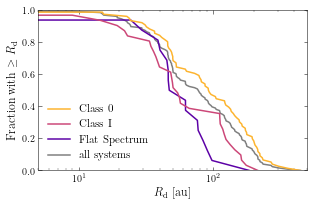

In [22]:
plt.figure(figsize=(4.5,3))
p4=plot_cumulative_dist(data_all[1], color='tab:grey')
p3=plot_cumulative_dist(data_Flat[1], color=colors[2])
p2=plot_cumulative_dist(data_I[1], color=colors[1])
p1=plot_cumulative_dist(data_0[1], color=colors[0])
plt.legend([p1,p2,p3,p4],['Class 0','Class I','Flat Spectrum','all systems'], frameon=False)
plt.xlim(5,500); plt.xscale('log'); plt.xlabel(r'$R_{\rm d}$ [au]')
plt.ylim(0,1); plt.ylabel(r'Fraction with $\geq R_{\rm d}$')
set_ticks()
plt.tight_layout()
#plt.savefig('../figures/class_Rd.pdf',bbox_inches='tight')

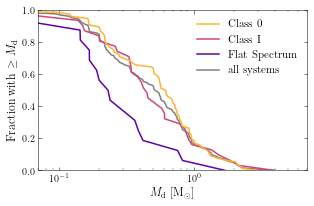

In [23]:
plt.figure(figsize=(4.5,3))
p4=plot_cumulative_dist(data_all[0], color='tab:grey')
p3=plot_cumulative_dist(data_Flat[0], color=colors[2])
p2=plot_cumulative_dist(data_I[0], color=colors[1])
p1=plot_cumulative_dist(data_0[0], color=colors[0])
plt.legend([p1,p2,p3,p4],['Class 0','Class I','Flat Spectrum','all systems'], frameon=False)
plt.xlim(7e-2,7); plt.xscale('log'); plt.xlabel(r'$M_{\rm d}$ [M$_\odot$]');
plt.ylim(0,1); plt.ylabel(r'Fraction with $\geq M_{\rm d}$')
set_ticks()
plt.tight_layout()
#plt.savefig('../figures/class_Md.pdf',bbox_inches='tight')

# Sensitvity to model parameters

In [31]:
def get_data_one(D):
    DM = D.disk_model
    Md_over_Mstar = (DM.M-DM.Mstar)/DM.Mstar
    T_mean = get_temperatures(D.disk_model, 0)[2]
    return [DM.Rd/au, (DM.M-DM.Mstar)/Msun, DM.Mstar/Msun, Md_over_Mstar, T_mean]
def get_data(Ds):
    d = [get_data_one(D) for D in Ds[chi_sq<=2]]
    return np.array(d)
def get_parameter_sensitivity(D1, D2, dlogx, s0=''):
    d1 = get_data(D1)
    d2 = get_data(D2)
    dlogy_mean = np.mean(np.log(d2)-np.log(d1), axis=0)/dlogx
    dlogy_std = np.std(np.log(d2)-np.log(d1), axis=0)/dlogx
    dlogy_rms = np.sqrt(np.mean((np.log(d2)-np.log(d1))**2, axis=0))/dlogx
    y_names = ['Rd','Md','Mstar','Md/Mstar','Tmean']
    s = s0
    for i in range(len(dlogy_mean)):
        #print(y_names[i]+' {:+.2f}$\pm${:.2f}'.format(dlogy_mean[i],dlogy_std[i]))
        s += '& ${:+.2f}\pm{:.2f}$ '.format(dlogy_mean[i],dlogy_std[i])
    s += r'\\'
    print(s)
    return dlogy_rms

In [32]:
with open('../data/fitted_systems/fit_1mm_Q1d5_age1e5.pkl','rb') as f:
    Ds = np.array(pickle.load(f))
with open('../data/fitted_systems/fit_1mm_Q1_age1e5.pkl','rb') as f:
    Ds_Q1 = np.array(pickle.load(f))
with open('../data/fitted_systems/fit_1mm_Q2_age1e5.pkl','rb') as f:
    Ds_Q2 = np.array(pickle.load(f))
with open('../data/fitted_systems/fit_1cm_Q1d5_age1e5.pkl','rb') as f:
    Ds_1cm = np.array(pickle.load(f))
with open('../data/fitted_systems/fit_100um_Q1d5_age1e5.pkl','rb') as f:
    Ds_100um = np.array(pickle.load(f))
with open('../data/fitted_systems/fit_1mm_Q1d5_age5e4.pkl','rb') as f:
    Ds_Mdot_double = np.array(pickle.load(f))
with open('../data/fitted_systems/fit_1mm_Q1d5_age2e5.pkl','rb') as f:
    Ds_Mdot_half = np.array(pickle.load(f))

In [33]:
# table 3
dlogy_rms_a = get_parameter_sensitivity(Ds_100um, Ds_1cm, np.log(100), r'$a_{\rm max}$')
dlogy_rms_Mdot = get_parameter_sensitivity(Ds_Mdot_half, Ds_Mdot_double, np.log(4), r'$\dot M/M_\star$')
dlogy_rms_Q = get_parameter_sensitivity(Ds_Q1, Ds_Q2, np.log(2), r'$Q$')

$a_{\rm max}$& $+0.03\pm0.10$ & $+0.01\pm0.05$ & $+0.04\pm0.13$ & $-0.03\pm0.11$ & $-0.04\pm0.05$ \\
$\dot M/M_\star$& $-0.03\pm0.13$ & $-0.16\pm0.06$ & $-0.45\pm0.20$ & $+0.30\pm0.22$ & $-0.01\pm0.08$ \\
$Q$& $-0.24\pm0.39$ & $-0.96\pm0.18$ & $+1.04\pm0.52$ & $-2.01\pm0.51$ & $+0.18\pm0.20$ \\


In [34]:
dlogx_est_a = np.log(10)
dlogx_est_Mdot = np.log(10)
dlogx_est_Q = np.log(2)/2
dlogy = np.sqrt( dlogy_rms_a**2   * dlogx_est_a**2
                +dlogy_rms_Mdot**2* dlogx_est_Mdot**2
                +dlogy_rms_Q**2   * dlogx_est_Q**2)

In [35]:
def print_rms(dlogy_rms, dlogx_est, s0, bold=False):
    dlogy = dlogy_rms*dlogx_est
    if bold: s0 = r'\textbf{'+s0+r'}'
    s = s0
    for i in range(len(dlogy)):
        if bold:
            s += r'& \textbf{'+'{:.2f}'.format(dlogy[i])+r'} '
        else:
            s += '& {:.2f} '.format(dlogy[i])
    s += r'\\'
    print(s)

In [36]:
# table 4
print_rms(dlogy_rms_a, dlogx_est_a, r'$a_{\rm max}$')
print_rms(dlogy_rms_Mdot, dlogx_est_Mdot, r'$\dot M/M_\star$')
print_rms(dlogy_rms_Q, dlogx_est_Q, r'$Q$')
print_rms(dlogy, 1, r'Total', True)

$a_{\rm max}$& 0.25 & 0.11 & 0.31 & 0.27 & 0.15 \\
$\dot M/M_\star$& 0.31 & 0.39 & 1.15 & 0.85 & 0.19 \\
$Q$& 0.16 & 0.34 & 0.40 & 0.72 & 0.09 \\
\textbf{Total}& \textbf{0.43} & \textbf{0.53} & \textbf{1.25} & \textbf{1.15} & \textbf{0.26} \\


# Estimate covariance (for scatter plots)

In [37]:
def get_cov(D1, D2, dlogx_D, dlogx_est):
    d1 = get_data(D1)
    d2 = get_data(D2)
    dlogy = np.log(d2)-np.log(d1)
    N = dlogy.shape[0]
    covy = np.transpose(dlogy).dot(dlogy)/N/dlogx_D**2*dlogx_est**2
    return covy

In [38]:
covy_a = get_cov(Ds_100um, Ds_1cm, np.log(100), np.log(10))
covy_Mdot = get_cov(Ds_Mdot_half, Ds_Mdot_double, np.log(4), np.log(10))
covy_Q = get_cov(Ds_Q1, Ds_Q2, np.log(2), np.log(2)/2)
covy = covy_a+covy_Mdot+covy_Q

In [39]:
np.sqrt(covy[0,0])

0.4305308294163217

In [40]:
# Mstar vs Mdisk
print(covy[2,2], covy[1,1], covy[2,1])

1.5744940391955033 0.2822320360727028 0.27173650979573905


In [41]:
# Rdisk vs Mdisk
print(covy[0,0], covy[1,1], covy[0,1])

0.1853567950779059 0.2822320360727028 0.06589718869756671


# How many systems' radius estimate is only a lower limit?

In [7]:
def get_F_edge_over_sigma_obs(D):
    I_edge = D.disk_model.I_obs[0][-1]
    sigma_obs = D.disk_image_list[0].rms_Jy
    F_edge_Jy_beam = I_edge*1e23*D.disk_image_list[0].beam_area
    return F_edge_Jy_beam/sigma_obs
F_over_sigma = np.array([get_F_edge_over_sigma_obs(D) for D in Ds])

In [25]:
np.sum(F_over_sigma<1.05)

25